<a href="https://colab.research.google.com/github/NobodydeBunny/Cat_Dog_breed_classifire_AI_model/blob/main/Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict, Counter
import random

In [2]:
(dataset, info) = tfds.load("oxford_iiit_pet",
                            with_info=True,
                            as_supervised=True)

train_ds = dataset['train']
test_ds = dataset['test']
class_names = info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XU0F2C_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XU0F2C_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
cat_labels = tf.constant(
    [i for i, name in enumerate(class_names) if name[0].isupper()],
    dtype=tf.int64
)

def is_cat(image, label):
    return tf.reduce_any(tf.equal(cat_labels, label))

train_ds = train_ds.filter(is_cat)
test_ds = test_ds.filter(is_cat)

cat_class_names = [class_names[i] for i in cat_labels.numpy()]
NUM_CLASSES = len(cat_class_names)

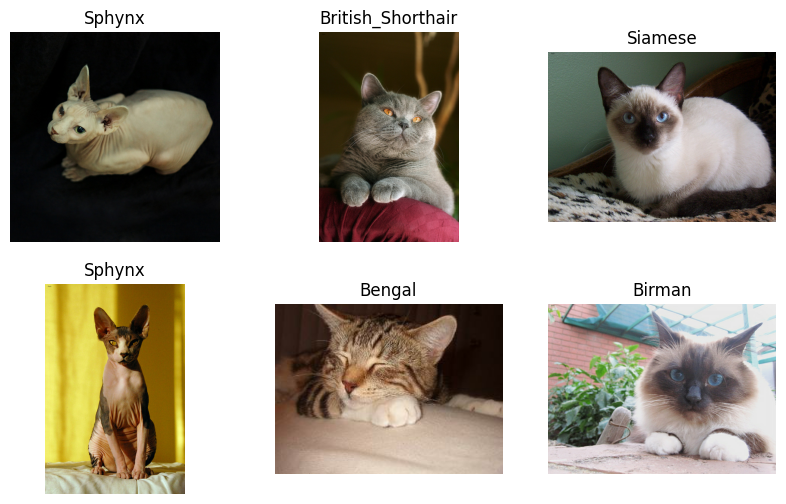

In [4]:
plt.figure(figsize=(10,6))

label_map = {int(original_idx): new_idx for new_idx, original_idx in enumerate(cat_labels.numpy())}

for i, (image, label) in enumerate(train_ds.take(6)):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(cat_class_names[label_map[int(label.numpy())]])
    plt.axis('off')

plt.show()

In [5]:
IMG_SIZE = 225

all_cats_ds = train_ds.concatenate(test_ds)

class_images = defaultdict(list)

for image, label in all_cats_ds:
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    class_images[int(label.numpy())].append((image, int(label.numpy())))

train_list, val_list, test_list = [], [], []

train_ratio = 0.8
val_ratio = 0.1

for class_idx, images in class_images.items():
    random.shuffle(images)

    total = len(images)
    n_train = int(total * train_ratio)
    n_val = int(n_train * val_ratio)
    n_train -= n_val

    train_list.extend(images[:n_train])
    val_list.extend(images[n_train:n_train+n_val])
    test_list.extend(images[n_train+n_val:])

def make_dataset(data_list):
    images = tf.stack([img for img, _ in data_list])
    labels = tf.constant([lbl for _, lbl in data_list], dtype=tf.int64)
    return tf.data.Dataset.from_tensor_slices((images, labels))

train_ds = make_dataset(train_list)
val_ds   = make_dataset(val_list)
test_ds  = make_dataset(test_list)

print("Train:", len(train_list))
print("Validation:", len(val_list))
print("Test:", len(test_list))

Train: 1709
Validation: 187
Test: 475


In [6]:
BATCH_SIZE = 32

label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(label_map.keys()), dtype=tf.int64),
        values=tf.constant(list(label_map.values()), dtype=tf.int64),
    ),
    default_value=-1
)

def preprocess(image, label):
    label = label_table.lookup(label)
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(len(train_list)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(len(val_list)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("Datasets ready.")

Datasets ready.


In [7]:
def show_class_distribution(dataset, name):
    counter = Counter()

    for _, labels in dataset.unbatch():
        counter[int(labels.numpy())] += 1

    print(f"\n{name} Distribution")
    total = sum(counter.values())
    for cls, count in sorted(counter.items()):
        print(f"{cat_class_names[cls]:<25} : {count}")
    print("Total:", total)

show_class_distribution(train_ds, "Train")
show_class_distribution(val_ds, "Validation")
show_class_distribution(test_ds, "Test")


Train Distribution
Abyssinian                : 141
Bengal                    : 143
Birman                    : 144
Bombay                    : 133
British_Shorthair         : 144
Egyptian_Mau              : 135
Maine_Coon                : 143
Persian                   : 144
Ragdoll                   : 141
Russian_Blue              : 142
Siamese                   : 142
Sphynx                    : 144
Total: 1696

Validation Distribution
Abyssinian                : 15
Bengal                    : 13
Birman                    : 15
Bombay                    : 11
British_Shorthair         : 13
Egyptian_Mau              : 12
Maine_Coon                : 13
Persian                   : 14
Ragdoll                   : 12
Russian_Blue              : 15
Siamese                   : 12
Sphynx                    : 15
Total: 160

Test Distribution
Abyssinian                : 40
Bengal                    : 40
Birman                    : 40
Bombay                    : 37
British_Shorthair         : 40
Eg

In [8]:
for x, y in train_ds.take(1):
    print(x.shape, y.shape)
    print(tf.reduce_min(x), tf.reduce_max(x))

(32, 225, 225, 3) (32,)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [9]:
for x, y in val_ds.take(1):
    print(tf.reduce_min(x), tf.reduce_max(x))

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [10]:
for img, label in val_ds.take(5):
    print(label.numpy())

[10  2  7  8  2  2  3 11  7  6  6 11  9  5  6  0  0  0  0 10  2  4  9  2
  0  3  1  2  7  0  8  3]
[11  9 10  6  1  0  1  6  6  9 11  5  2 11  4 11  9  4  1  7 10  9  8  0
  2  1  4  5  6  5  1  7]
[ 8  7  5  5  2  7  5 10 10  1  3  5  8  5  7  9  6  8  2  9 10  4  9  4
  0 10 10  4 10  0 11  3]
[ 8  7 11  6  8  8 11  2  3  5  1  7  3  0  9  5  8  4  1  9  7  8  3  9
 11  6 10  1  3  7  7 11]
[ 7  5  7  5  2  6  0 11  7  0  3  4  3  4  9 10  8  1  4  6  1  2  8 10
  4  2  0  9  4  1  6  2]


In [11]:
model = tf.keras.Sequential([
    # First Convolutional Block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Fourth Convolutional Block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Fifth Convolutional Block
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 301ms/step - accuracy: 0.1214 - loss: 3.5631 - val_accuracy: 0.0875 - val_loss: 2.5265
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.1473 - loss: 3.3128 - val_accuracy: 0.0688 - val_loss: 2.7377
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.1526 - loss: 3.1632 - val_accuracy: 0.0750 - val_loss: 3.7667
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.1524 - loss: 3.2767 - val_accuracy: 0.0938 - val_loss: 5.3571
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.1577 - loss: 3.2097 - val_accuracy: 0.0688 - val_loss: 6.1330
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.1728 - loss: 3.1043 - val_accuracy: 0.0875 - val_loss: 4.9237
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.1813 - loss: 3.1082 - val_accuracy: 0.0875 - val_loss: 6.2116
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.2145 - loss: 2.9440 - val_accu

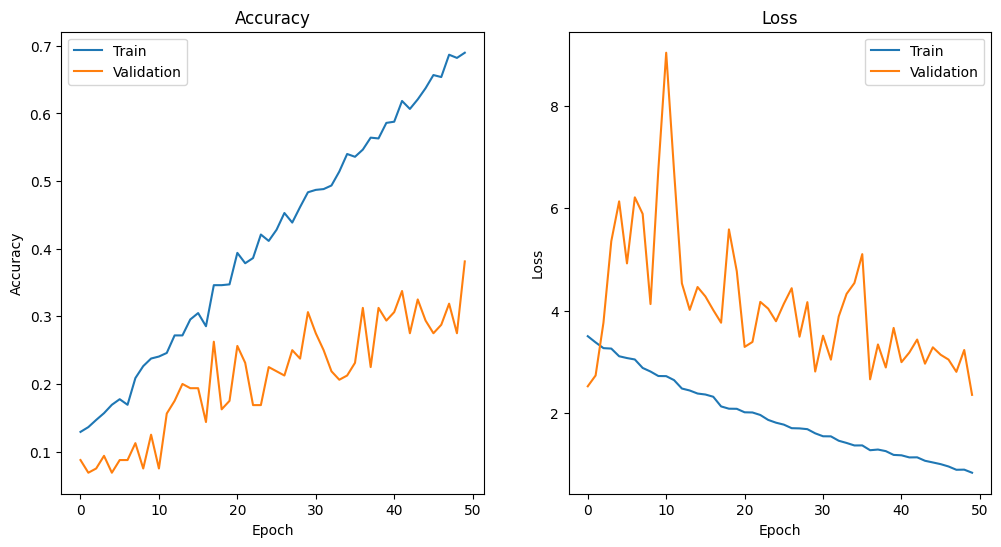

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3146 - loss: 3.6561
Test Loss: 2.8694
Test Accuracy: 0.3750


In [16]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=cat_class_names))

                   precision    recall  f1-score   support

       Abyssinian       0.47      0.35      0.40        40
           Bengal       0.77      0.42      0.55        40
           Birman       0.37      0.78      0.50        40
           Bombay       1.00      0.35      0.52        37
British_Shorthair       0.33      0.50      0.40        40
     Egyptian_Mau       0.62      0.68      0.65        38
       Maine_Coon       0.33      0.20      0.25        40
          Persian       0.09      0.62      0.16        13
          Ragdoll       0.31      0.30      0.30        40
     Russian_Blue       0.42      0.33      0.37        40
          Siamese       0.33      0.07      0.12        40
           Sphynx       0.75      0.07      0.14        40

         accuracy                           0.38       448
        macro avg       0.48      0.39      0.36       448
     weighted avg       0.50      0.38      0.37       448



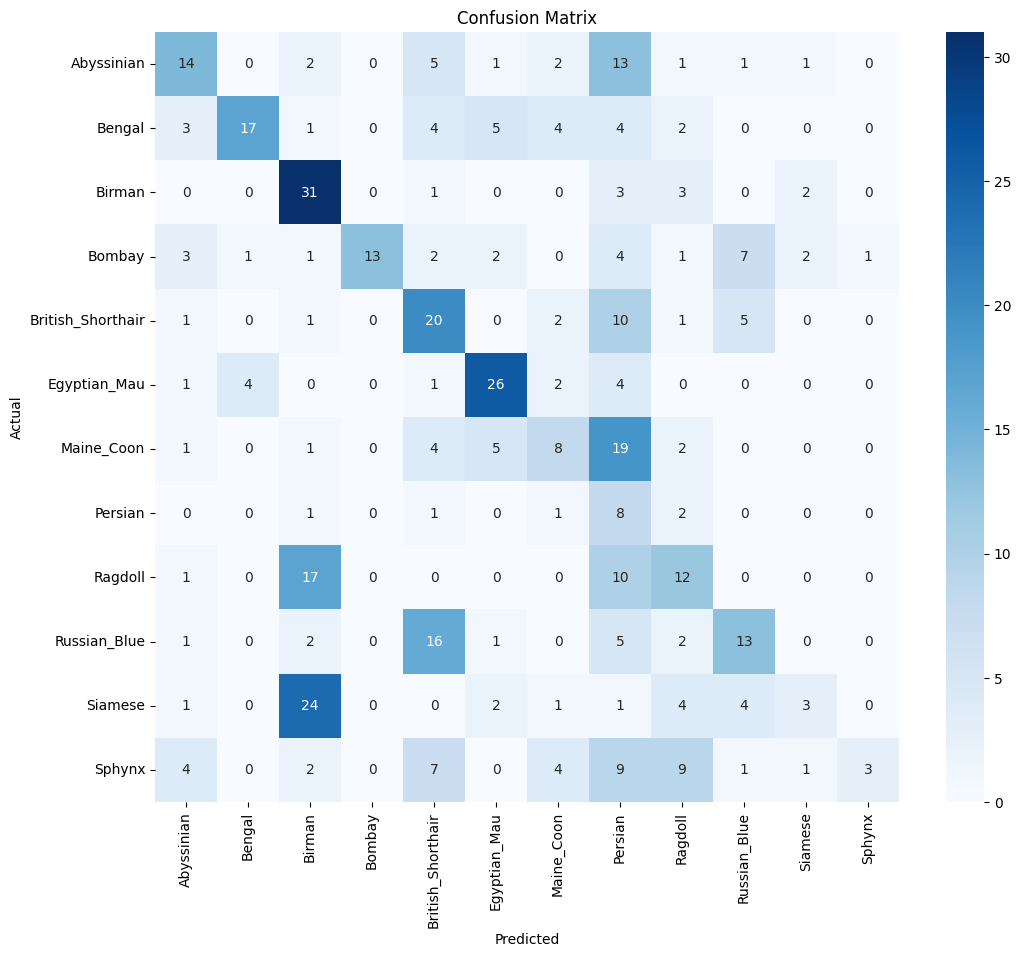

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cat_class_names,
            yticklabels=cat_class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
def predict_and_display_random():
    test_list = list(test_ds.unbatch())

    index = random.randint(0, len(test_list) - 1)

    image, label = test_list[index]
    input_img = tf.expand_dims(image, axis=0)

    probs = model.predict(input_img, verbose=0)[0]
    pred_class = np.argmax(probs)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"True: {cat_class_names[label.numpy()]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.barh(cat_class_names, probs*100)
    plt.xlim(0, 100)
    plt.title(f"Predicted: {cat_class_names[pred_class]}")
    plt.show()

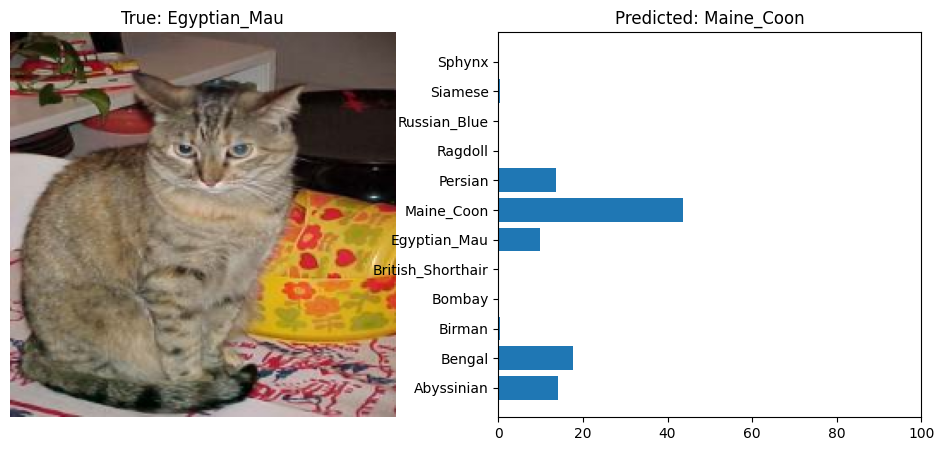

In [26]:
predict_and_display_random()

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/cat_breed_model_v5.keras")
print("Model saved successfully.")